In [20]:
import numpy as np
import cvxopt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

In [21]:
del_t = 0.1
v_init = 1
w_init = 0

class agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.v)+" "+str(self.w)+" "+str(self.pos))
    
    def optimizer(self,cost_hist):
        theta_new = self.theta + self.w*del_t
        xgi = self.pos[0] + self.v*del_t*np.cos(theta_new) - self.goal[0]
        ygi = self.pos[1] + self.v*del_t*np.sin(theta_new) - self.goal[1]
        p_mat = 2*np.array([[del_t**2,0],
                          [0,(self.v**2)*(del_t**4)]])
        P = cvxopt.matrix(p_mat,tc='d')
        q_mat = np.array([2*del_t*(xgi*np.cos(theta_new)+ygi*np.sin(theta_new)),
                         -2*del_t**2*self.v*(xgi*np.sin(theta_new)-ygi*np.cos(theta_new))])
#             print (p_mat,q_mat)
        Q = cvxopt.matrix(q_mat,tc='d')
        g_mat = np.array([[1,0],[0,1],[0,-1]])
        h = cvxopt.matrix(np.array([self.vmax-self.v,self.wmax-self.w,self.wmax-self.w]),tc='d')
        g = cvxopt.matrix(g_mat,tc='d')
        sol = cvxopt.solvers.qp(P,Q,g,h,options={'show_progress': False})
        v_new = sol['x'][0]
        w_new = sol['x'][1]
        x_new = self.pos[0] + (self.v+v_new)*del_t*np.cos(self.theta+(self.w+w_new)*del_t)
        y_new = self.pos[1] + (self.v+v_new)*del_t*np.sin(self.theta+(self.w+w_new)*del_t)
        cost = np.linalg.norm(np.array([x_new,y_new])- self.goal)**2
        self.v += v_new
        self.w += w_new
        prev_cost = cost_hist[-1]
        print ("cost:",cost)
        return cost_hist        
            

    def opt_traj(self):
        self.visualize_traj()
        cost_hist = []
        cost_hist.append(0)
        while (np.linalg.norm(self.pos-self.goal)>0.5):
#             self.visualize_traj()
            cost_hist = self.optimizer(cost_hist)
            print ("v_new: ",self.v,"w_new: ",self.w)
            self.vplot.append(self.v)
            self.wplot.append(self.w)
            x_new = self.pos[0] + self.v*del_t*np.cos(self.theta+self.w*del_t)
            y_new = self.pos[1] + self.v*del_t*np.sin(self.theta+self.w*del_t)
            self.theta = self.theta+self.w*del_t
            self.xpath.append(x_new)
            self.ypath.append(y_new)
            self.pos = [x_new,y_new]
            print (self)
            self.time+=1
            self.visualize_traj()

             
    def visualize_traj(self):
        figure = plt.figure()
#         print (self.pos)
        print ("I wanna rotate by: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="red", markersize =15,linewidth=3.0)
        ax.plot(self.xpath,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 100.0)
        ax.set_ylim(-10.0, 100.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


I wanna rotate by:  0.7853981633974483
cost: 4859.5786432928735
v_new:  10.000000033697594 w_new:  0.0
0 0.7853981633974483 10.000000033697594 0.0 [0.7071067835693272, 0.7071067835693271]
I wanna rotate by:  0.7853981633974483
cost: 4721.157287058043
v_new:  10.000000000310093 w_new:  7.104998441209843e-14
1 0.7853981633974554 10.000000000310093 7.104998441209843e-14 [1.4142135647777967, 1.4142135647778067]
I wanna rotate by:  0.7853981633974554
cost: 4584.735930823734
v_new:  10.000000000280718 w_new:  -9.733868317428067e-12
2 0.785398163396482 10.000000000280718 -9.733868317428067e-12 [2.121320345984877, 2.121320345983521]
I wanna rotate by:  0.785398163396482
cost: 4450.31457458996
v_new:  10.000000000248935 w_new:  1.3130804759562298e-09
3 0.7853981635277901 10.000000000248935 1.3130804759562298e-09 [2.8284271270968615, 2.8284271272798365]
I wanna rotate by:  0.7853981635277901
cost: 4317.893218356734
v_new:  10.000000000214863 w_new:  -1.7451972396321826e-07
4 0.7853981460758177 1

cost: 1894.376295851215
v_new:  -21.780373028574505 w_new:  0.5000000000306497
38 2.189613919170855 -21.780373028574505 0.5000000000306497 [14.546523981952937, 24.752676694568652]
I wanna rotate by:  2.189613919170855
cost: 1889.6443004420114
v_new:  -21.753150284712955 w_new:  0.5000000000424549
39 2.2396139191751003 -21.753150284712955 0.5000000000424549 [15.895347113384727, 23.046021593733215]
I wanna rotate by:  2.2396139191751003
cost: 1884.9241252012453
v_new:  -21.725964375694858 w_new:  0.5000000000175818
40 2.2896139191768583 -21.725964375694858 0.5000000000175818 [17.325991592052137, 21.410958397340465]
I wanna rotate by:  2.2896139191768583
cost: 1880.2157405437847
v_new:  -21.698812666489697 w_new:  0.5000000000345952
41 2.339613919180318 -21.698812666489697 0.5000000000345952 [18.83467941789233, 19.85139251046177]
I wanna rotate by:  2.339613919180318
cost: 1875.5191170566106
v_new:  -21.671694721555685 w_new:  0.5000000000121015
42 2.389613919181528 -21.671694721555685 0.

cost: 1718.3233203235077
v_new:  -20.743621115004924 w_new:  0.5000000000197037
77 4.139613919240264 -20.743621115004924 0.5000000000197037 [84.83682776630707, 27.534053514170278]
I wanna rotate by:  4.139613919240264
cost: 1714.0310907237022
v_new:  -20.717696834951166 w_new:  0.5000000000065187
78 4.189613919240916 -20.717696834951166 0.5000000000065187 [85.87123434405656, 29.329111355399366]
I wanna rotate by:  4.189613919240916
cost: 1709.749582726175
v_new:  -20.69180526666418 w_new:  0.5000000000190964
79 4.239613919242825 -20.69180526666418 0.5000000000190964 [86.8134536881628, 31.171319475978454]
I wanna rotate by:  4.239613919242825
cost: 1705.4787696147077
v_new:  -20.66594573822471 w_new:  0.5000000000063243
80 4.2896139192434575 -20.66594573822471 0.5000000000063243 [87.66136247422386, 33.055958386505594]
I wanna rotate by:  4.2896139192434575
cost: 1701.2186246080096
v_new:  -20.640118850052243 w_new:  0.5000000000184871
81 4.3396139192453065 -20.640118850052243 0.50000000

cost: 1562.5348286578846
v_new:  -19.780942640853922 w_new:  0.5000000000081121
115 6.039613919274744 -19.780942640853922 0.5000000000081121 [59.533192576598935, 88.36213064931826]
I wanna rotate by:  6.039613919274744
cost: 1558.6317458416393
v_new:  -19.756221365647725 w_new:  0.5000000000022774
116 6.089613919274972 -19.756221365647725 0.5000000000022774 [57.5944681754252, 88.74217080874655]
I wanna rotate by:  6.089613919274972
cost: 1554.7384125544133
v_new:  -19.73153148409878 w_new:  0.5000000000075241
117 6.139613919275724 -19.73153148409878 0.5000000000075241 [55.64161616898597, 89.02448692239591]
I wanna rotate by:  6.139613919275724
cost: 1550.8548045415725
v_new:  -19.706871954860347 w_new:  0.5000000000020604
118 6.18961391927593 -19.706871954860347 0.5000000000020604 [53.679549959553846, 89.20861788735634]
I wanna rotate by:  6.18961391927593
cost: 1546.980897410418
v_new:  -19.682243752361664 w_new:  0.5000000000069413
119 6.239613919276624 -19.682243752361664 0.50000000

I wanna rotate by:  7.889613919281395
cost: 1420.8706016824972
v_new:  -18.862940376313283 w_new:  0.499999999999977
153 7.939613919281393 -18.862940376313283 0.499999999999977 [12.4436828385421, 46.776082670030114]
I wanna rotate by:  7.939613919281393
cost: 1417.3213843395
v_new:  -18.83936661266205 w_new:  0.49999999999997424
154 7.98961391928139 -18.83936661266205 0.49999999999997424 [12.698422756204785, 44.90944801964668]
I wanna rotate by:  7.98961391928139
cost: 1413.7810326481247
v_new:  -18.815822310076477 w_new:  0.49999999999997147
155 8.039613919281386 -18.815822310076477 0.49999999999997147 [13.045702611994239, 43.06019184653097]
I wanna rotate by:  8.039613919281386
cost: 1410.2495244627057
v_new:  -18.79230743173815 w_new:  0.49999999999996875
156 8.089613919281383 -18.79230743173815 0.49999999999996875 [13.484423772411569, 41.23289002978266]
I wanna rotate by:  8.089613919281383
cost: 1406.7268376928955
v_new:  -18.768821940875917 w_new:  0.499999999999966
157 8.1396139

cost: 1292.050089792781
v_new:  -17.987541252640504 w_new:  0.49999999999988587
191 9.839613919281113 -17.987541252640504 0.49999999999988587 [64.48730550339512, 17.103676967720567]
I wanna rotate by:  9.839613919281113
cost: 1288.8226554429805
v_new:  -17.965061509945176 w_new:  0.4999999999998841
192 9.889613919281102 -17.965061509945176 0.4999999999998841 [66.09319357318479, 17.909007867331617]
I wanna rotate by:  9.889613919281102
cost: 1285.603282957476
v_new:  -17.94260986107475 w_new:  0.49999999999988237
193 9.93961391928109 -17.94260986107475 0.49999999999988237 [67.6548707996659, 18.79248776328718]
I wanna rotate by:  9.93961391928109
cost: 1282.391952198397
v_new:  -17.92018627091895 w_new:  0.4999999999998807
194 9.989613919281078 -17.92018627091895 0.4999999999998807 [69.16854667721516, 19.751714586082393]
I wanna rotate by:  9.989613919281078
cost: 1279.1886430781756
v_new:  -17.89779070441185 w_new:  0.49999999999987915
195 10.039613919281067 -17.89779070441185 0.4999999

cost: 1171.9740177103083
v_new:  -17.131331519394458 w_new:  0.4999999999998701
230 11.7896139192806 -17.131331519394458 0.4999999999998701 [73.99708183673452, 74.41544759023218]
I wanna rotate by:  11.7896139192806
cost: 1169.0465234656886
v_new:  -17.109921815913818 w_new:  0.4999999999998716
231 11.839613919280586 -17.109921815913818 0.4999999999998716 [72.71840033346197, 75.55231515448735]
I wanna rotate by:  11.839613919280586
cost: 1166.1263418597682
v_new:  -17.088538868987882 w_new:  0.49999999999987327
232 11.889613919280572 -17.088538868987882 0.49999999999987327 [71.38616418430784, 76.62251534587963]
I wanna rotate by:  11.889613919280572
cost: 1163.2134546261798
v_new:  -17.067182645177127 w_new:  0.49999999999987504
233 11.93961391928056 -17.067182645177127 0.49999999999987504 [70.00383498015776, 77.62354142235924]
I wanna rotate by:  11.93961391928056
cost: 1160.3078435441853
v_new:  -17.04585311108652 w_new:  0.49999999999987693
234 11.989613919280549 -17.04585311108652 

KeyboardInterrupt: 

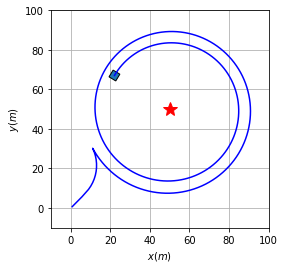

In [22]:
bot = agent(2,np.array([0,0]),np.array([50,50]),np.pi/4,10,0.5)
bot.opt_traj()

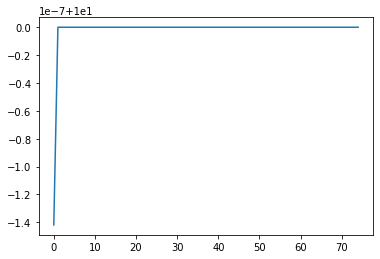

In [16]:
plt.plot(bot.vplot)

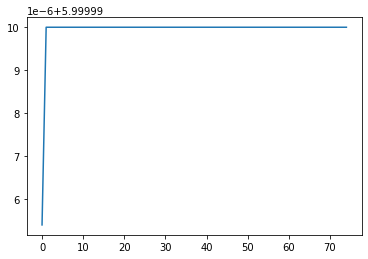

In [17]:
plt.plot(bot.wplot)